## A simple example to illustrate the functionality of LSTMs

In [ ]:
import torch
import torch.nn as nn

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the Dataset 'Tips' from the seaborn library

In [4]:
tip_data = sns.load_dataset("tips")
tip_data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### I will be using the first 2 columns to demonstrate usage of LSTMs

In [5]:
tip_data = tip_data[['total_bill','tip']]
tip_data

,total_bill,tip
0,16.99,1.01
1,10.34,1.66
2,21.01,3.50
3,23.68,3.31
4,24.59,3.61
...,...,...
239,29.03,5.92
240,27.18,2.00
241,22.67,2.00
242,17.82,1.75


In [6]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 25
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

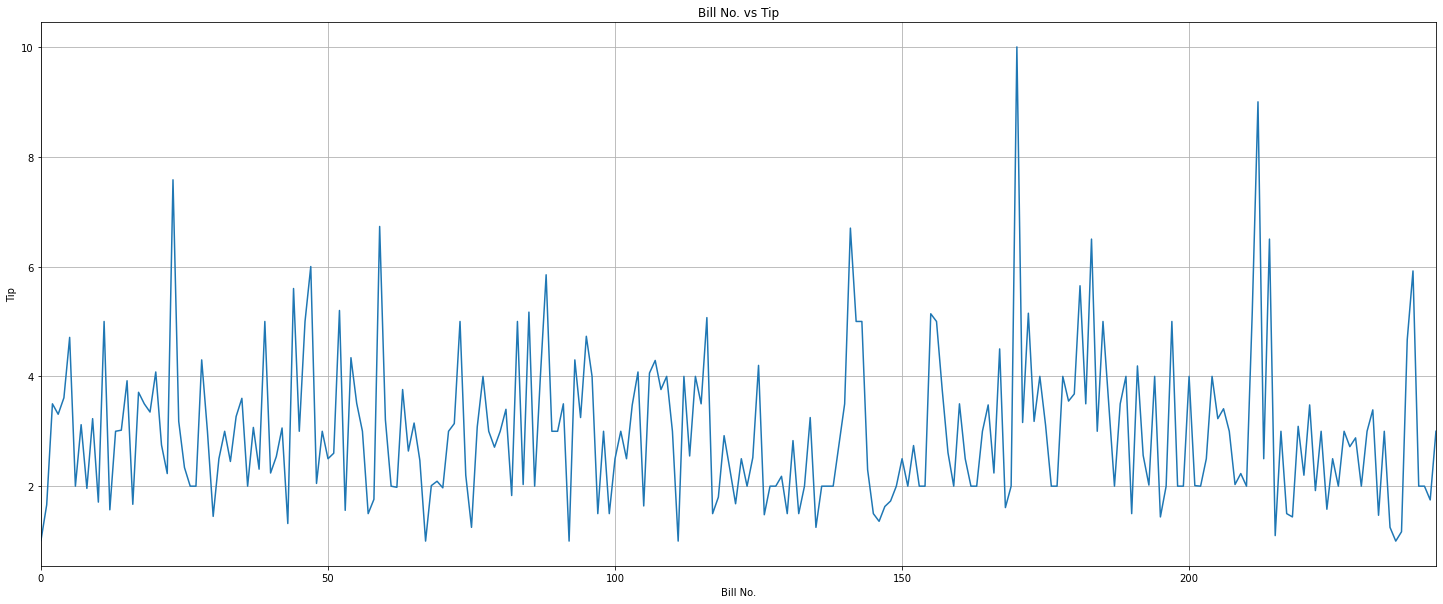

In [7]:
plt.title('Bill No. vs Tip')
plt.ylabel('Tip')
plt.xlabel('Bill No.')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(tip_data['tip'])

### Data Pre - Processing

##### Splitting dataset into Training and Testing Data

In [8]:
all_data = tip_data['tip'].values.astype(float)

test_data_size = 50  # Last 50 values will be predicted by the model trained on the first 194 values

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]


##### Normalizing the values in the range from -1 to 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
# The data needs to be converted to tensors since Pytorch models take only tensors as input
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

##### Sequences of "Tip" data are made

In [ ]:
# Tip data of sequence length 'tw' is made and the [tw+1] data is assigned to be the output/label of the sequence
# The tip sequences and label pairs are constructed and stores in an array
train_window = 15
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [ ]:
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1): # input and output is one number each - "tips", hidden layer
                                                                            # hidden layer contains 100 neurons
        super().__init__()
        self.hidden_layer_size = hidden_layer_size                          # initializing the layers

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))        # output of LSTM layer is current LSTM cell state and previous
                                                                            # hidden cell state. So we initialize the hidden cell state with
                                                                            # the hidden_layer_size

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
# Initializing an instance of the model
model = LSTM()
print(model)

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
loss_function = nn.MSELoss()  # Using 'Cross-Entropy' loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Defining Adam optimizer

#### Training the model

In [ ]:
epochs = 200

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad() # initializing the optimizer with zero gradient since PyTorch accumulates the gradients on backward passes
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward() # is responsible for accumulation of the gradient
        optimizer.step() # performs a parameter update based on the gradient
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.15771379
epoch:  26 loss: 0.09446696
epoch:  51 loss: 0.05167751
epoch:  76 loss: 0.09977424
epoch: 101 loss: 0.09061844
epoch: 126 loss: 0.15957747
epoch: 151 loss: 0.13271032
epoch: 176 loss: 0.06946808
epoch: 199 loss: 0.0716592446

##### Predicting values based on the trained model

In [ ]:
# Collecting the last 50 values for testing
fut_pred = 50

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.4333333373069763, -0.40444445610046387, 0.03333333507180214, -0.4444444477558136, 0.2222222238779068, -0.5555555820465088, -0.1111111119389534, -0.4444444477558136, -0.7777777910232544, -0.4444444477558136, -0.3333333432674408, -0.8888888955116272, -0.2911111116409302, -0.653333306312561, -0.7733333110809326]

In [ ]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
        
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1)) # Inverting normalization to obtain actual values

In [ ]:
tip_data.shape
x = np.arange(194,244,1) # For plotting the graph

#### Plotting the actual and predicted data for comparison

NameError: name 'x' is not defined

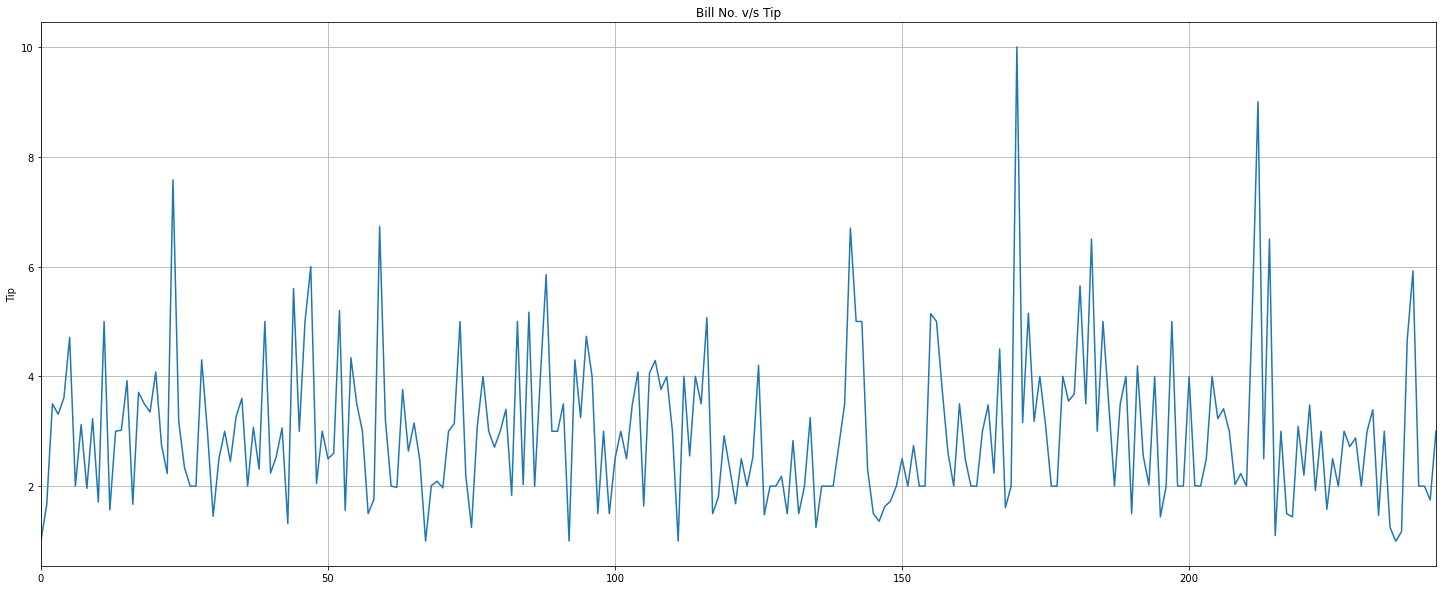

In [13]:
plt.title('Bill No. v/s Tip')
plt.ylabel('Tip')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(tip_data['tip'], label = 'Original Data')
plt.plot(x,actual_predictions, label = "Predicted Data")
plt.legend(loc="upper left",prop={'size': 15})
plt.show()

# The last 50 tip values are predicted

### The End